In [ ]:
#%pip install ydata_profiling

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd "/content/drive/MyDrive/winter_2023/fds/project"

/content/drive/MyDrive/winter_2023/fds/project


In [6]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter
import seaborn as sns

warnings.filterwarnings('ignore')


# 1 -OverView of the data


Our Datasets contains stats of players in NBA season for every year from 2014 to 2023.

We also have a rookies datasets which shows  for every year , show aggregateds stats of the whole carrier rookies drafted that year. A rookie is a new player who never played in The NBA, debuting in a certain season.

Our goal is to study the carreer of the player staring from his rookie years. So we will combine this two data to have a more detailled and complete informations on every rookie stats each year of theri carrier.

We will try to see how the first years performances can have an incidence on the longevity of the carrier of a rookie



## 1.1 Import Data

In [7]:
# Directory containing all datasets
directory = './dataset_nba'

# List of CSV files in the directory
csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

# Dictionary to memorize DataFrames
dataframes = {}

# Importa i file CSV e assegna loro nomi basati sul titolo del file
for file_name in csv_files:
    # Estrai il titolo del file (senza l'estensione .csv)
    title = os.path.splitext(file_name)[0]

    # Costruisci il percorso completo del file
    file_path = os.path.join(directory, file_name)

    # Leggi il file CSV in un DataFrame e assegna il titolo come chiave
    dataframes[title] = pd.read_csv(file_path)
    dataframes[title]['Season'] = str(title[:4])

dataframes['2014-players'].head(5)


,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ID,Season
0,1,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,...,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,acyqu01,2014
1,1,Quincy Acy,SF,23,TOR,7,0,8.7,0.9,2.0,...,1.4,2.1,0.6,0.6,0.4,0.3,1.1,2.7,acyqu01,2014
2,1,Quincy Acy,SF,23,SAC,56,0,14.0,1.1,2.3,...,2.4,3.6,0.4,0.3,0.4,0.5,2.0,2.7,acyqu01,2014
3,2,Steven Adams,C,20,OKC,81,20,14.8,1.1,2.3,...,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3,adamsst01,2014
4,3,Jeff Adrien,PF,27,TOT,53,12,18.1,2.7,5.2,...,3.8,5.8,0.7,0.5,0.7,0.7,2.0,6.8,adrieje01,2014


In [8]:
dataframes['2014-players'].columns

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ID',
       'Season'],
      dtype='object')

## 1.2 Features

For Every year for both rookies and players, here are the features in the dataset

- **Player**: Name of the player.
- **Age**: Age during their rookie year.
- **Yrs**: Years played in the NBA.
- **G**: Number of games played.
- **MP**: Total minutes played.
- **FG, FGA**: Field goals made and attempted.
- **3P, 3PA**: Three-point field goals made and attempted.
- **2P, 2PA**: Two-point field goals made and attempted.
- **FT, FTA**: Free throws made and attempted.
- **TRB**: Total rebounds.
- **DRB**: Defensive rebounds.
- **ORB**: Offensive rebounds.
- **AST**: Assists.
- **STL**: Steals.
- **BLK**: Blocks.
- **PF**: Personal fouls.
- **PTS**: Points per game.
- **FG%**, **3P%**,**2P%**, **FT%**, **eFG%**: Shooting percentages.
- **ID**: Unique identifier for the player.
- **Season**: Season Played.
for the player.

### 1.3 Organize our  data

We can get players or rookies from a particular year

In [9]:
def get_players_data(year):
    """
     Return the dataset of a particular year for all players
    """
    data = dataframes[f'{year}-players']
    if year == 2016:
      data.rename(columns={'Player-additional': 'ID'}, inplace=True) # 2016 data has a different column namr for ID

    return data.copy()

def get_rookies_data_at_draft(year):
    """
     Return the dataset of a particular year for  only rookies drafted that year
    """
    return dataframes[f'{year}-rookies'].copy()


def get_all_rookies_ids(start_year, end_year):
    rookies_ids = []
    for year in range(start_year, end_year):
        ids = get_rookies_data_at_draft['ID'].tolist()
        rookies_ids.extend(ids)
    return list(set(rookies_ids))

In [10]:
players_2014 = get_players_data(2014)
players_2014.head(5)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,ID,Season
0,1,Quincy Acy,SF,23,TOT,63,0,13.4,1.0,2.2,...,2.3,3.4,0.4,0.4,0.4,0.5,1.9,2.7,acyqu01,2014
1,1,Quincy Acy,SF,23,TOR,7,0,8.7,0.9,2.0,...,1.4,2.1,0.6,0.6,0.4,0.3,1.1,2.7,acyqu01,2014
2,1,Quincy Acy,SF,23,SAC,56,0,14.0,1.1,2.3,...,2.4,3.6,0.4,0.3,0.4,0.5,2.0,2.7,acyqu01,2014
3,2,Steven Adams,C,20,OKC,81,20,14.8,1.1,2.3,...,2.3,4.1,0.5,0.5,0.7,0.9,2.5,3.3,adamsst01,2014
4,3,Jeff Adrien,PF,27,TOT,53,12,18.1,2.7,5.2,...,3.8,5.8,0.7,0.5,0.7,0.7,2.0,6.8,adrieje01,2014


For our purposes we will build a dataset with all the rookies stats from 2014

In [11]:
# from ydata_profiling import ProfileReport
# profile = ProfileReport(players_2014, title="Profiling report")


## 2- Data Preprocessing

### 2.1 Standadize Player roles

In [12]:
#Defining a custom function to standardize roles
def standadize_role(role):
    roles = {
        "SG-SF": "SG",
        "SF-SG": "SF",
        "SG-PG": "SG",
        "PF-SF": "PF",
        "C-PF": "C",
        "SF-PF": "SF",
        "PF-C": "PF"

    }
    return roles.get(role, role)

### 2.1 Aggregate stats for each players for a given season

Some players change teams during the year so we need to aggregate their stats, by performing adequate operations

In [13]:

# Defining functions for aggregation
# def weighted_average(group, avg_name, weight_name):
#     """ Calculate weighted average for a group. """
#     d = group[avg_name]
#     w = group[weight_name]
#     try:
#         return (d * w).sum() / w.sum()
#     except ZeroDivisionError:
#         return 0

def impute_missing_values(df, cols= ["3P","FT","2P","FG"]):
    # For shooting percentages, we can replace missing values with 0, assuming missing values indicate no attempts or no successes
    for col in cols:
        df[col] = df[col].fillna(0, inplace=False)

    return df


def impute_raw_missing_values(df, cols= ["3PA","FTA","2PA","FGA"]):
    # For shooting percentages, we can replace missing values with 0, assuming missing values indicate no attempts or no successes
    for col in cols:
        df[col] = df[col].fillna(1, inplace=False)

    return df



# Aggregating the data
def aggregate_stats(df):

    my_data = df.copy()
    #first we get the total minutes played
    my_data["MP"] = my_data["MP"] * my_data["G"]
    my_data["PTS"] = my_data["PTS"] * my_data["G"]
    #the we aggregate for the season
    aggregated_stats = my_data.groupby('ID').agg({
        ## for quantified values, we do the sum
        'G': 'sum',  # Summing up games played
        'GS': 'sum',  # Summing up games started
        'FG': 'sum',  # Summing up field goals
        'FGA': 'sum', # Summing up field goal attempts
        '2P': 'sum',  # Summing up two-point field goals
        '3P': 'sum',  # Summing up three-point field goals
        '2PA': 'sum', # Summing up two-point attempts
        '3PA': 'sum', # Summing up three-point attempts
        'FT': 'sum',  # Summing up free throws
        'FTA': 'sum', # Summing up free throw attempts
        'ORB': 'sum', # Summing up offensive rebounds
        'DRB': 'sum', # Summing up defensive rebounds
        'TRB': 'sum', # Summing up total rebounds
        'AST': 'sum', # Summing up assists
        'STL': 'sum', # Summing up steals
        'BLK': 'sum', # Summing up blocks
        'TOV': 'sum', # Summing up turnovers
        'PF': 'sum',  # Summing up personal fouls
        'MP': 'sum',  # Summing up all  minutes played
        'PTS': 'sum',  # Summing up all points

        ## for categorical values we take the mode
        'Season': lambda x: x.mode().iloc[0], # Season
        'Pos' : lambda x: x.mode().iloc[0] # Most played position of the player
    }).reset_index()

    return aggregated_stats

def compute_percentage(aggregated_stats):
  aggregated_stats["FG%"] = aggregated_stats["FG"] / aggregated_stats["FGA"]
  aggregated_stats["3P%"] = aggregated_stats["3P"] / aggregated_stats["3PA"]
  aggregated_stats["2P%"] = aggregated_stats["2P"] / aggregated_stats["2PA"]
  aggregated_stats["FT%"] = aggregated_stats["FT"] / aggregated_stats["FTA"]

  # Calculate eFG% after imputing missing values
  aggregated_stats['eFG%'] = (aggregated_stats['FG'] + 0.5 * aggregated_stats['3P']) / aggregated_stats['FGA']

  for col in ["3P%","FT%","2P%","FG%","eFG%"]:
        aggregated_stats[col] = aggregated_stats[col].fillna(0, inplace=False)
  return aggregated_stats



In [14]:
#### let write a function to perform al the preprocessing at once
def preprocess_season_data(df):
  #aggreate values for the season
  prep_df = aggregate_stats(df)

  #impute missing values
  prep_df = impute_missing_values(prep_df)
  prep_df = impute_raw_missing_values(prep_df)

  prep_df = compute_percentage(prep_df)
  return prep_df

In [15]:
players_2014_preprocessed = preprocess_season_data(get_players_data(2014))
players_2014_preprocessed.head(5)

,ID,G,GS,FG,FGA,2P,3P,2PA,3PA,FT,...,PF,MP,PTS,Season,Pos,FG%,3P%,2P%,FT%,eFG%
0,acyqu01,126,0,3.0,6.5,2.6,0.4,5.4,1.1,1.8,...,5.0,1689.1,340.2,2014,SF,0.461538,0.363636,0.481481,0.666667,0.492308
1,adamsst01,81,20,1.1,2.3,1.1,0.0,2.3,0.0,1.0,...,2.5,1198.8,267.3,2014,C,0.478261,0.000000,0.478261,0.588235,0.478261
2,adrieje01,106,24,7.9,15.2,7.9,0.0,15.2,0.0,4.2,...,6.0,1919.9,723.1,2014,PF,0.519737,0.000000,0.519737,0.636364,0.519737
3,afflaar01,73,73,6.4,13.8,4.6,1.8,9.7,4.1,3.8,...,1.9,2555.0,1328.6,2014,SG,0.463768,0.439024,0.474227,0.826087,0.528986
4,ajincal01,56,30,2.4,4.4,2.4,0.0,4.4,0.0,1.0,...,3.3,952.0,330.4,2014,C,0.545455,0.000000,0.545455,0.833333,0.545455


### 2.3 Build our dataset over a number of seasons

To study the progression of a rookie , we need a dataset get rookies drafted a certain year and their progress over the next years

In [16]:
def get_all_rookies_data_at_draft(start_year, current_year):
    """
     Return the dataset of a range of  years for all rookies drafted in a particular year.
    """

    df_final = pd.DataFrame()
    ## considering a start year
    ## we retrieve data of all successives years for these same rookies
    for year in range(start_year, current_year+1):
          df_start_year_rookies = get_rookies_data_at_draft(year)
          df_final = pd.concat([df_start_year_rookies, df_final], ignore_index=True)

    return df_final



def get_rookies_carrier_data(start_year, current_year, rookies_ids=None):
    """
     Return the dataset of a range of  years for all rookies drafted in a particular year.
    """

    if not rookies_ids:
      rookies_ids = get_rookies_data_at_draft(start_year)["ID"]

    df_final = pd.DataFrame()
    ## considering a start year
    ## we retrieve data of all successives years for these same rookies
    for year in range(start_year, current_year+1):
          df_players_of_year = preprocess_season_data(get_players_data(year))
          df_start_year_rookies = df_players_of_year[df_players_of_year['ID'].isin(rookies_ids)]
          df_final = pd.concat([df_start_year_rookies, df_final], ignore_index=True)

    return df_final




In [17]:
# here we get rookies drafted in 2014 and following seasons
start_year = 2014
current_year = 2023

# all time rookies and ids
all_rookies_data_at_draft = get_all_rookies_data_at_draft(start_year, current_year)
all_rookies_ids = list(set(all_rookies_data_at_draft['ID'].tolist()))

# all rookies carrier data
rookies_carrier_data = get_rookies_carrier_data(start_year,current_year, all_rookies_ids)
rookies_carrier_data.sort_values(by=["ID","Season"],ascending=[True,True], inplace=True)
rookies_carrier_data.reset_index(drop=True,inplace=True)
rookies_carrier_data.shape

(3135, 28)

In [18]:
rookies_carrier_data.head(10)

,ID,G,GS,FG,FGA,2P,3P,2PA,3PA,FT,...,PF,MP,PTS,Season,Pos,FG%,3P%,2P%,FT%,eFG%
0,abrinal01,68,6,2.0,5.0,0.6,1.4,1.4,3.6,0.6,...,1.7,1054.0,408.0,2017,SG,0.400000,0.388889,0.428571,0.857143,0.540000
1,abrinal01,75,8,1.5,3.9,0.4,1.1,0.9,2.9,0.5,...,1.7,1132.5,352.5,2018,SG,0.384615,0.379310,0.444444,0.833333,0.525641
2,abrinal01,31,2,1.8,5.1,0.5,1.3,1.0,4.1,0.4,...,1.7,589.0,164.3,2019,SG,0.352941,0.317073,0.500000,1.000000,0.480392
3,achiupr01,61,4,2.0,3.7,2.0,0.0,3.7,0.0,0.9,...,1.5,738.1,305.0,2021,PF,0.540541,0.000000,0.540541,0.500000,0.540541
4,achiupr01,73,28,3.6,8.3,2.9,0.8,6.1,2.1,1.1,...,2.1,1722.8,664.3,2022,C,0.433735,0.380952,0.475410,0.611111,0.481928
5,achiupr01,55,12,3.6,7.3,3.0,0.5,5.4,2.0,1.6,...,1.9,1138.5,506.0,2023,C,0.493151,0.250000,0.555556,0.695652,0.527397
6,adamsja01,34,1,1.1,3.2,0.4,0.7,1.1,2.2,0.2,...,1.3,428.4,108.8,2019,PG,0.343750,0.318182,0.363636,0.666667,0.453125
7,adamsja01,7,0,0.1,1.1,0.1,0.0,0.9,0.3,0.0,...,0.1,18.2,2.1,2021,PG,0.090909,0.000000,0.111111,0.000000,0.090909
8,adamsjo01,30,0,1.2,2.9,0.8,0.3,2.0,0.8,0.5,...,0.8,249.0,93.0,2015,SG,0.413793,0.375000,0.400000,0.625000,0.465517
9,adamsjo01,2,0,1.0,3.0,1.0,0.0,2.5,0.5,1.5,...,1.0,15.0,7.0,2016,SG,0.333333,0.000000,0.400000,0.600000,0.333333


In [19]:
## save data to file
## With this we have all the stats for each year for all rookies
rookies_carrier_data.to_csv("./dataset_nba/rookies_carrier_data")

### 2.4 Filter rookies

From this dataset we retain only rookies present for at a certain numbers of season from 1 to 3

In [20]:
def carrier_length(df):
  season_count = df.groupby('ID')['Season'].count()
  dd = pd.DataFrame(season_count.reset_index())
  dd = dd.rename(columns={"Season":"carrier_length"})
  return dd


def filter_players(df, min_season):
    season_count = carrier_length(df)

    # Filter to get IDs with min_season or more seasons
    ids_with_min_season = season_count[season_count["carrier_length"] >= min_season]["ID"]

    # Step 3: Filter the original DataFrame to include only those IDs
    df_filtered = df[df['ID'].isin(ids_with_min_season)]
    return df_filtered

In [21]:
rookies_data_carrier_length = carrier_length(rookies_carrier_data)
rookies_data_carrier_length.head(5)

,ID,carrier_length
0,abrinal01,3
1,achiupr01,3
2,adamsja01,2
3,adamsjo01,2
4,adamsst01,10


In [22]:
rookies_data_filtered = filter_players(rookies_carrier_data, min_season= 3)
rookies_data_filtered = rookies_data_filtered.sort_values(by=["ID","Season"])
rookies_data_filtered.shape

(2427, 28)

## 3 Features Engineering

### 3.1 Normalize Stats per game  

Because every player does not play same amount of game time . We can normalize the main Stats .

In [23]:
def normalize_stats_per_game(df):
    df['PTS_per_game'] = df['PTS'] / df['MP']
    df['AST_per_game'] = df['AST'] / df['MP']
    df['REB_per_game'] = df['TRB'] / df['MP']
    return df

In [24]:

# normalize data
normalized_rookies_data = normalize_stats_per_game(rookies_data_filtered)

# Display the first few rows of the combined dataset and check for any inconsistencies
normalized_rookies_data.shape


(2427, 31)

In [25]:
normalized_rookies_data.to_csv("./dataset_nba/normalized_rookies_data.csv",sep=",", index=False)

#### Graph to show the differences between the average PTS RBS and AST in year 1,2,3 in NBA

In [26]:
start_year = 2017
year_1=normalized_rookies_data[normalized_rookies_data["Season"]==str(start_year)]
year_2=normalized_rookies_data[normalized_rookies_data["Season"]==str(start_year+1)]
year_3=normalized_rookies_data[normalized_rookies_data["Season"]==str(start_year+2)]

PTS = []
AST = []
REB = []

for i in range(3):
    data = normalized_rookies_data[normalized_rookies_data["Season"]==str(start_year+i)]
    PTS.append(data["PTS_per_game"].mean())
    AST.append(data["AST_per_game"].mean())
    REB.append(data["REB_per_game"].mean())

# We computed the average points rebounds and assists per game respectively in year 1 2 and 3.

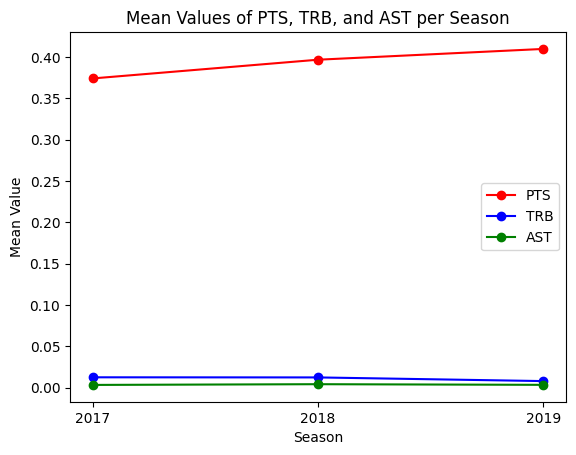

In [27]:
fig, ax1 = plt.subplots()

# Plot the PTS data as a line with red color
ax1.plot(['2017','2018','2019'], PTS, color='red', label='PTS', marker = 'o')

# Plot the TRB data as a line with blue color
ax1.plot(['2017','2018','2019'], REB, color='blue', label='TRB', marker = 'o')

# Plot the AST data as a line with green color
ax1.plot(['2017','2018','2019'], AST, color='green', label='AST', marker = 'o')

plt.xticks(['2017','2018','2019'])
# Add a legend
ax1.legend(loc='center right')

# Set the x-axis label and y-axis label
ax1.set_xlabel('Season')
ax1.set_ylabel('Mean Value')

# Set the title of the graph
ax1.set_title('Mean Values of PTS, TRB, and AST per Season')
plt.show()

# pt assist rimbalzi

* The graph above shows how the points made the rebounds and assists grow every year. In particular the increase of the points per game is the higher between the three, starting from an average of 6.04 Points per game and reaching the value of 8.48 in year 3.

#### Histograms of Points, Rebounds and Assists per game

In [28]:
def plot(df):
  # Set the aesthetic style of the plots
  sns.set_style("whitegrid")

  # Create a figure with multiple subplots
  fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))

  # Points per game distribution
  sns.histplot(df['PTS'], kde=True, ax=axes[0, 0], bins=30, color='skyblue')
  axes[0, 0].set_title('Distribution of Points per Game')

  # Rebounds per game distribution
  sns.histplot(df['TRB'], kde=True, ax=axes[0, 1], bins=30, color='lightgreen')
  axes[0, 1].set_title('Distribution of Rebounds per Game')

  # Assists per game distribution
  sns.histplot(df['AST'], kde=True, ax=axes[0, 2], bins=30, color='salmon')
  axes[0, 2].set_title('Distribution of Assists per Game')

  # Scatter plot of Points vs Rebounds
  sns.scatterplot(x='PTS', y='TRB', data=df, ax=axes[1, 0], color='purple')
  axes[1, 0].set_title('Points vs Rebounds')

  # Scatter plot of Points vs Assists
  sns.scatterplot(x='PTS', y='AST', data=df, ax=axes[1, 1], color='orange')
  axes[1, 1].set_title('Points vs Assists')

  # Correlation heatmap
  corr = df[['PTS', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF']].corr()
  sns.heatmap(corr, annot=True, cmap='coolwarm', ax=axes[1, 2])
  axes[1, 2].set_title('Correlation Heatmap')

  plt.tight_layout()
  plt.show()

* Year 1

In [29]:
# year_1[["PTS","AST","TRB"]].hist(figsize=(10, 10), bins=40,density=True)
# plt.show()

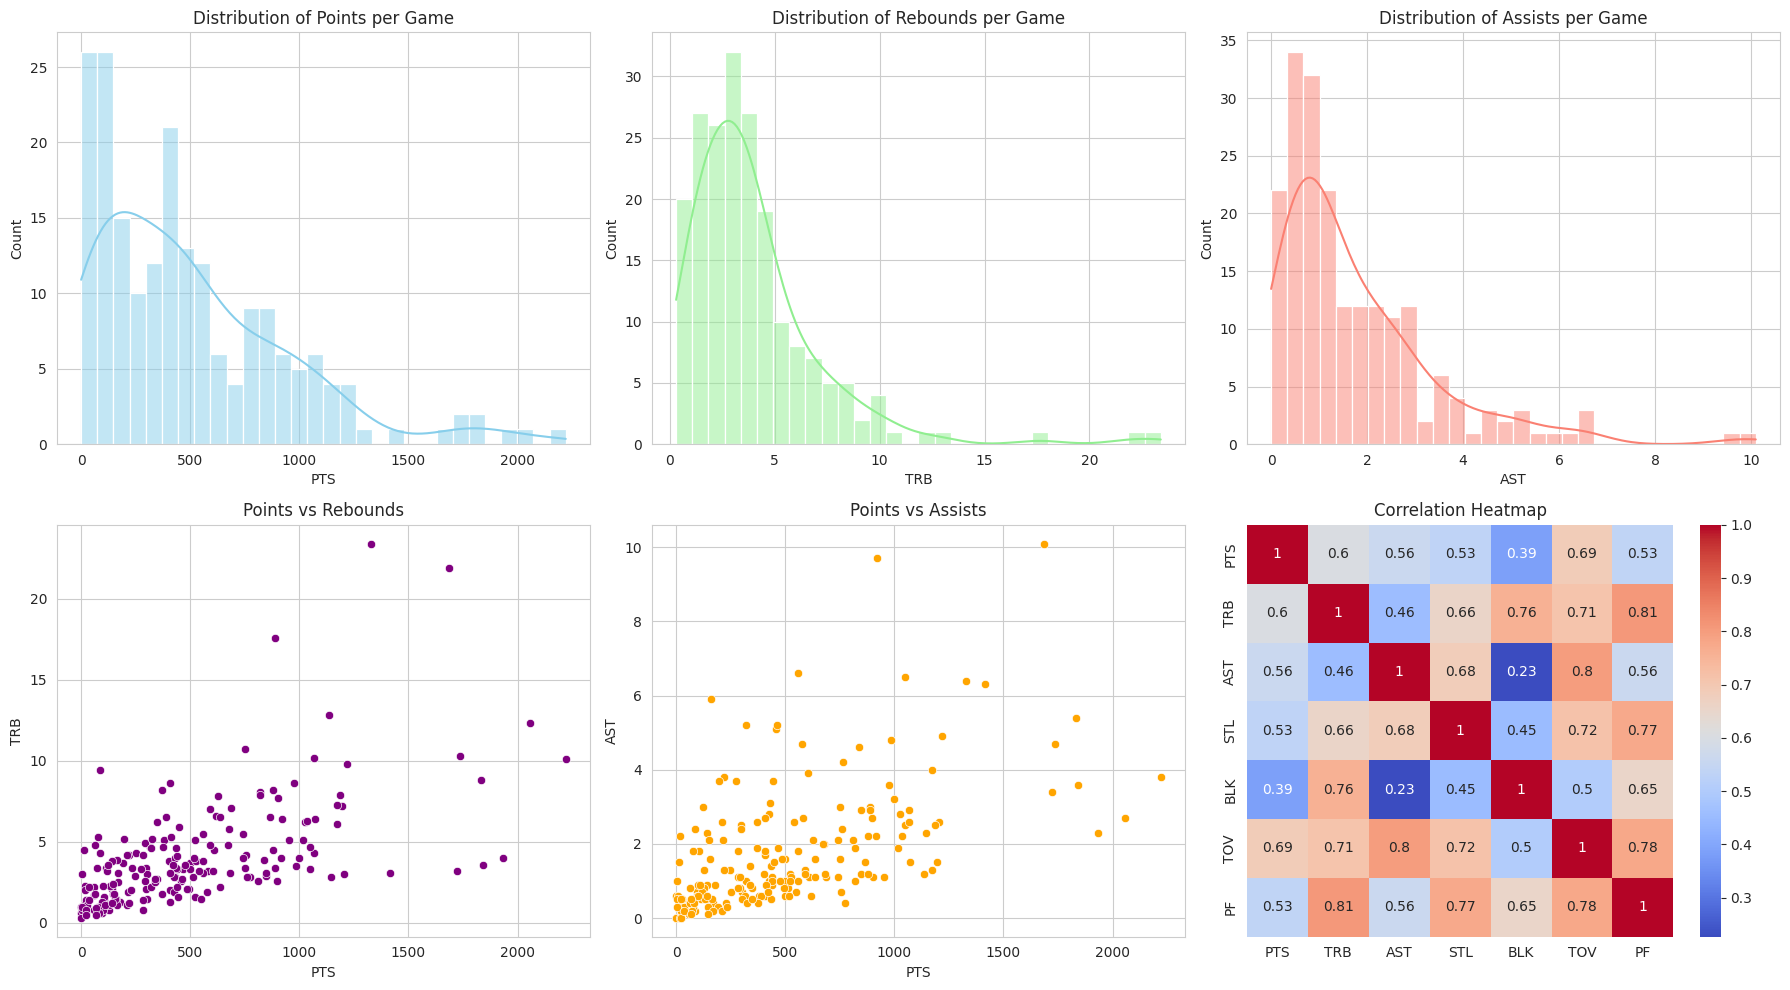

In [30]:
plot(year_1)

* Year 2

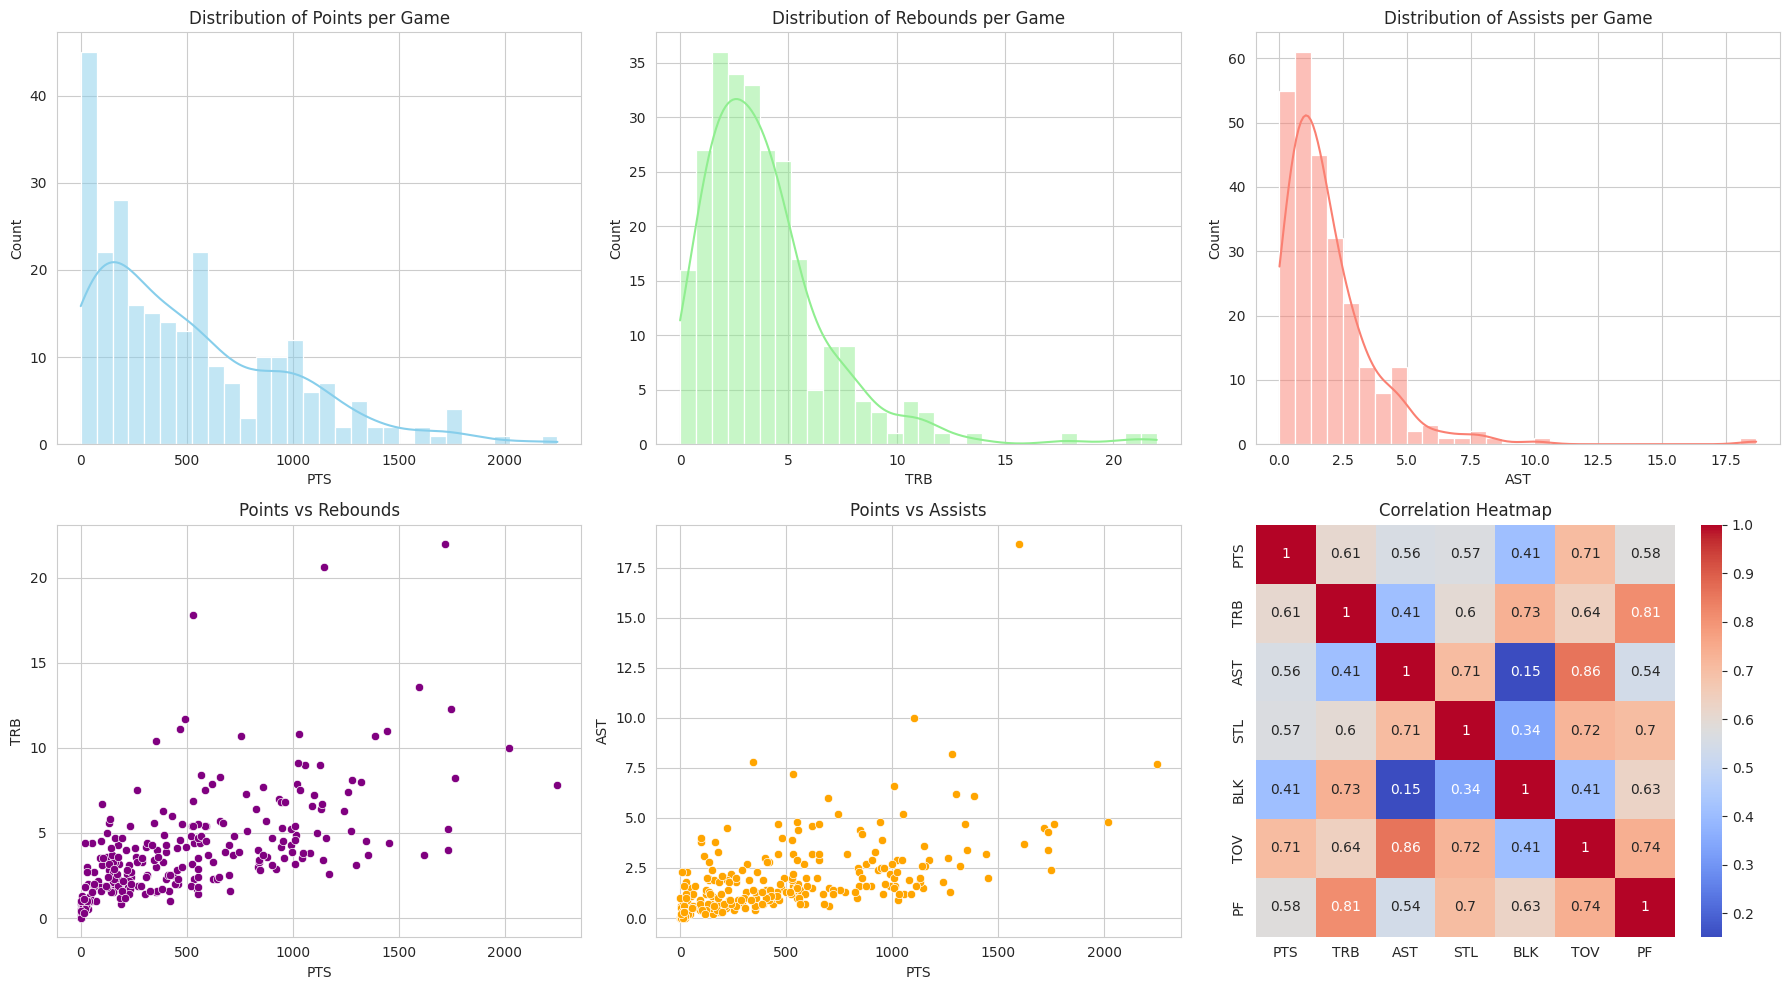

In [31]:
plot(year_2)

* Year 3

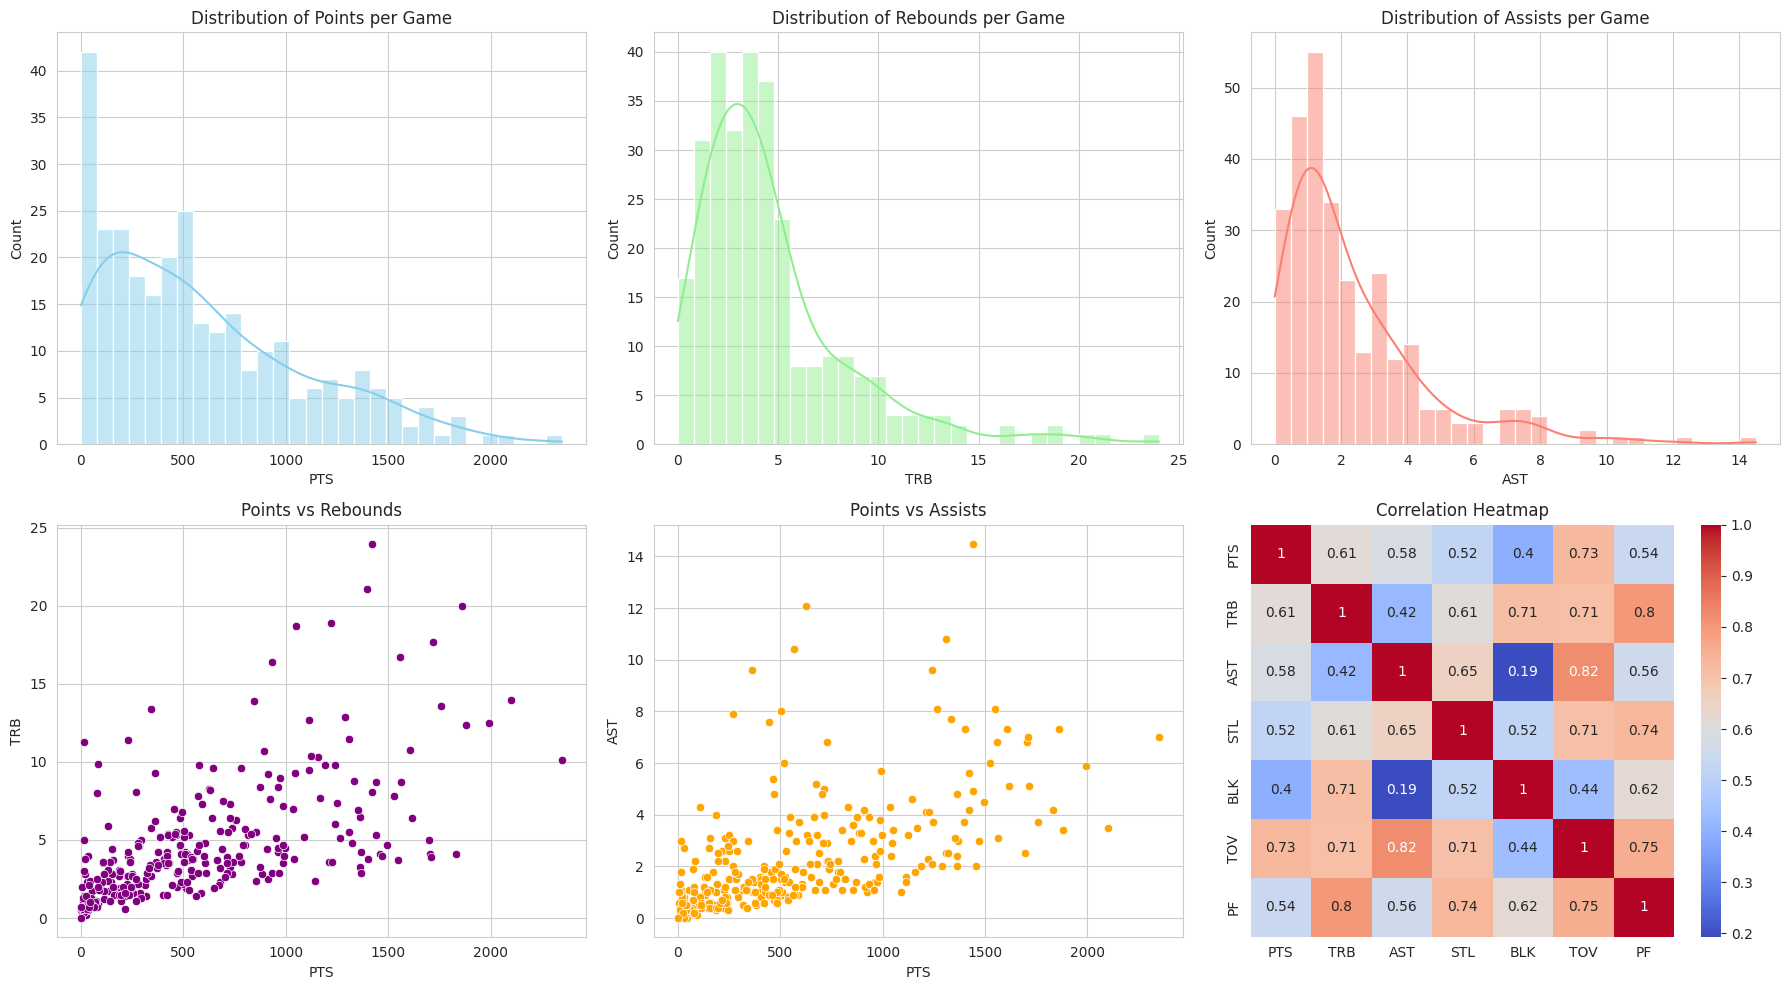

In [32]:
plot(year_3)

##### Histogram Observations:



**Points Per Game (PTS)**: The distribution is right-skewed, meaning most players score below the average, with a few high-scoring outliers.


**Assists Per Game (AST)**: Similar to points, the distribution is right-skewed, with most players recording fewer assists.


**Rebounds Per Game (TRB)**: This distribution also shows a right skew, with fewer players having high rebound numbers.
Steals Per Game (STL): Steals are relatively rare events, and the distribution reflects this with most players having low steal numbers.

### 3.2 Average performance over first years

To have a good indicator of rookies evolutions we will take an average of a 1 to  3 first years of performance

In [33]:
def average_stats_on_first_years(df, seasons = 3):
    data = df.copy()
    aggregated_stats = data.groupby(['ID','Season']).head(seasons)
    average_performances = aggregated_stats.groupby("ID").agg({
        ## quantified values
        'G': 'mean',  # Summing up games played
        'GS': 'mean',  # Summing up games started
        'FG': 'mean',  # Summing up field goals
        'FGA': 'mean', # Summing up field goal attempts
        '2P': 'mean',  # Summing up two-point field goals
        '3P': 'mean',  # Summing up three-point field goals
        '2PA': 'mean', # Summing up two-point attempts
        '3PA': 'mean', # Summing up three-point attempts
        'FT': 'mean',  # Summing up free throws
        'FTA': 'mean', # Summing up free throw attempts
        'ORB': 'mean', # Summing up offensive rebounds
        'DRB': 'mean', # Summing up defensive rebounds
        'TRB': 'mean', # Summing up total rebounds
        'AST': 'mean', # Summing up assists
        'STL': 'mean', # Summing up steals
        'BLK': 'mean', # Summing up blocks
        'TOV': 'mean', # Summing up turnovers
        'PF': 'mean',  # Summing up personal fouls
        'MP': 'mean',  # Summing up all  minutes played
        'PTS': 'mean',  # Summing up all points


        ## Unique or fixed values
        'Pos' : lambda x: x.mode().iloc[0] # Most played position of the player
    }).reset_index()


    average_performances = compute_percentage(average_performances)
    average_performances = normalize_stats_per_game(average_performances)

    return average_performances

In [34]:
rookies_data_filtered_avg = average_stats_on_first_years(normalized_rookies_data)
rookies_data_filtered_avg

,ID,G,GS,FG,FGA,2P,3P,2PA,3PA,FT,...,PTS,Pos,FG%,3P%,2P%,FT%,eFG%,PTS_per_game,AST_per_game,REB_per_game
0,abrinal01,58.000000,5.333333,1.766667,4.666667,0.500000,1.266667,1.100000,3.533333,0.500000,...,308.266667,SG,0.378571,0.358491,0.454545,0.882353,0.514286,0.333201,0.000576,0.001549
1,achiupr01,63.000000,14.666667,3.066667,6.433333,2.633333,0.433333,5.066667,1.366667,1.200000,...,491.766667,C,0.476684,0.317073,0.519737,0.610169,0.510363,0.409874,0.000695,0.004417
2,adamsst01,70.600000,64.100000,3.840000,6.530000,3.840000,0.000000,6.490000,0.010000,1.520000,...,653.180000,C,0.588055,0.000000,0.591680,0.524138,0.588055,0.344568,0.000844,0.004442
3,adebaba01,69.666667,52.333333,5.733333,10.366667,5.733333,0.000000,10.216667,0.150000,3.483333,...,1024.516667,C,0.553055,0.000000,0.561175,0.754513,0.553055,0.501370,0.001696,0.004184
4,alexani01,85.250000,15.500000,5.650000,14.275000,3.150000,2.500000,6.925000,7.325000,1.725000,...,720.925000,SG,0.395797,0.341297,0.454874,0.718750,0.483363,0.457527,0.002491,0.002808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,youngjo01,42.333333,0.333333,1.266667,3.266667,0.966667,0.300000,2.266667,1.000000,0.400000,...,143.933333,PG,0.387755,0.300000,0.426471,0.750000,0.433673,0.400854,0.002599,0.002692
473,youngtr01,70.600000,70.600000,8.180000,18.660000,5.660000,2.540000,11.460000,7.220000,6.860000,...,1797.600000,PG,0.438371,0.351801,0.493892,0.875000,0.506431,0.752966,0.003912,0.001558
474,zelleco01,50.900000,27.500000,3.120000,5.800000,3.060000,0.060000,5.520000,0.270000,1.930000,...,429.900000,C,0.537931,0.222222,0.554348,0.725564,0.543103,0.384186,0.001171,0.005165
475,zizican01,37.666667,9.000000,2.166667,3.666667,2.166667,0.000000,3.666667,0.000000,0.966667,...,225.133333,C,0.590909,0.000000,0.590909,0.725000,0.590909,0.446074,0.000925,0.006803


### 3.4 Target

Our target will be the number of years, a rookie lasted in NBA

In [35]:
rookies_dataset = all_rookies_data_at_draft[["ID","Age"]]
final_data = pd.merge(rookies_dataset, rookies_data_filtered_avg, on='ID')


final_data = normalize_stats_per_game(final_data)
final_data = pd.merge(final_data,rookies_data_carrier_length,on="ID")

In [36]:
final_data

,ID,Age,G,GS,FG,FGA,2P,3P,2PA,3PA,...,Pos,FG%,3P%,2P%,FT%,eFG%,PTS_per_game,AST_per_game,REB_per_game,carrier_length
0,achiupr01,21,63.000000,14.666667,3.066667,6.433333,2.633333,0.433333,5.066667,1.366667,...,C,0.476684,0.317073,0.519737,0.610169,0.510363,0.409874,0.000695,0.004417,3
1,anthoco01,20,57.333333,34.333333,4.933333,11.966667,3.433333,1.500000,7.600000,4.366667,...,PG,0.412256,0.343511,0.451754,0.852632,0.474930,0.500348,0.002803,0.003048,3
2,avdijde01,20,70.666667,26.666667,2.900000,6.833333,1.933333,0.966667,3.733333,3.133333,...,SF,0.424390,0.308511,0.517857,0.723404,0.495122,0.328293,0.001140,0.003134,3
3,azubuud01,21,22.666667,3.333333,1.366667,1.833333,1.366667,0.000000,1.833333,0.000000,...,C,0.745455,0.000000,0.745455,0.578947,0.745455,0.363102,0.000490,0.013714,3
4,ballla01,19,54.000000,47.333333,7.033333,16.633333,4.100000,2.900000,8.900000,7.733333,...,PG,0.422846,0.375000,0.460674,0.826531,0.510020,0.610061,0.004284,0.003683,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,snellto01,22,72.666667,35.777778,2.544444,5.900000,1.111111,1.411111,2.244444,3.633333,...,SG,0.431262,0.388379,0.495050,0.872340,0.550847,0.276925,0.000805,0.001754,9
473,thompho01,22,76.250000,24.750000,3.525000,8.975000,1.875000,1.675000,4.325000,4.675000,...,SG,0.392758,0.358289,0.433526,0.719298,0.486072,0.313598,0.000850,0.002523,4
474,witheje01,23,41.200000,3.000000,1.120000,2.180000,1.060000,0.040000,1.940000,0.220000,...,C,0.513761,0.181818,0.546392,0.680000,0.522936,0.323173,0.000579,0.005401,5
475,woltena01,22,35.000000,10.333333,2.000000,5.333333,1.900000,0.100000,4.666667,0.700000,...,PG,0.375000,0.142857,0.407143,0.520000,0.384375,0.276185,0.003508,0.004330,3


In [37]:
target = final_data["carrier_length"]
#final_data.drop(columns=["Yrs"], inplace=True)
final_data.shape



(477, 32)

### 4 - Data Analysis

#### 4.1 Correlation Matrix

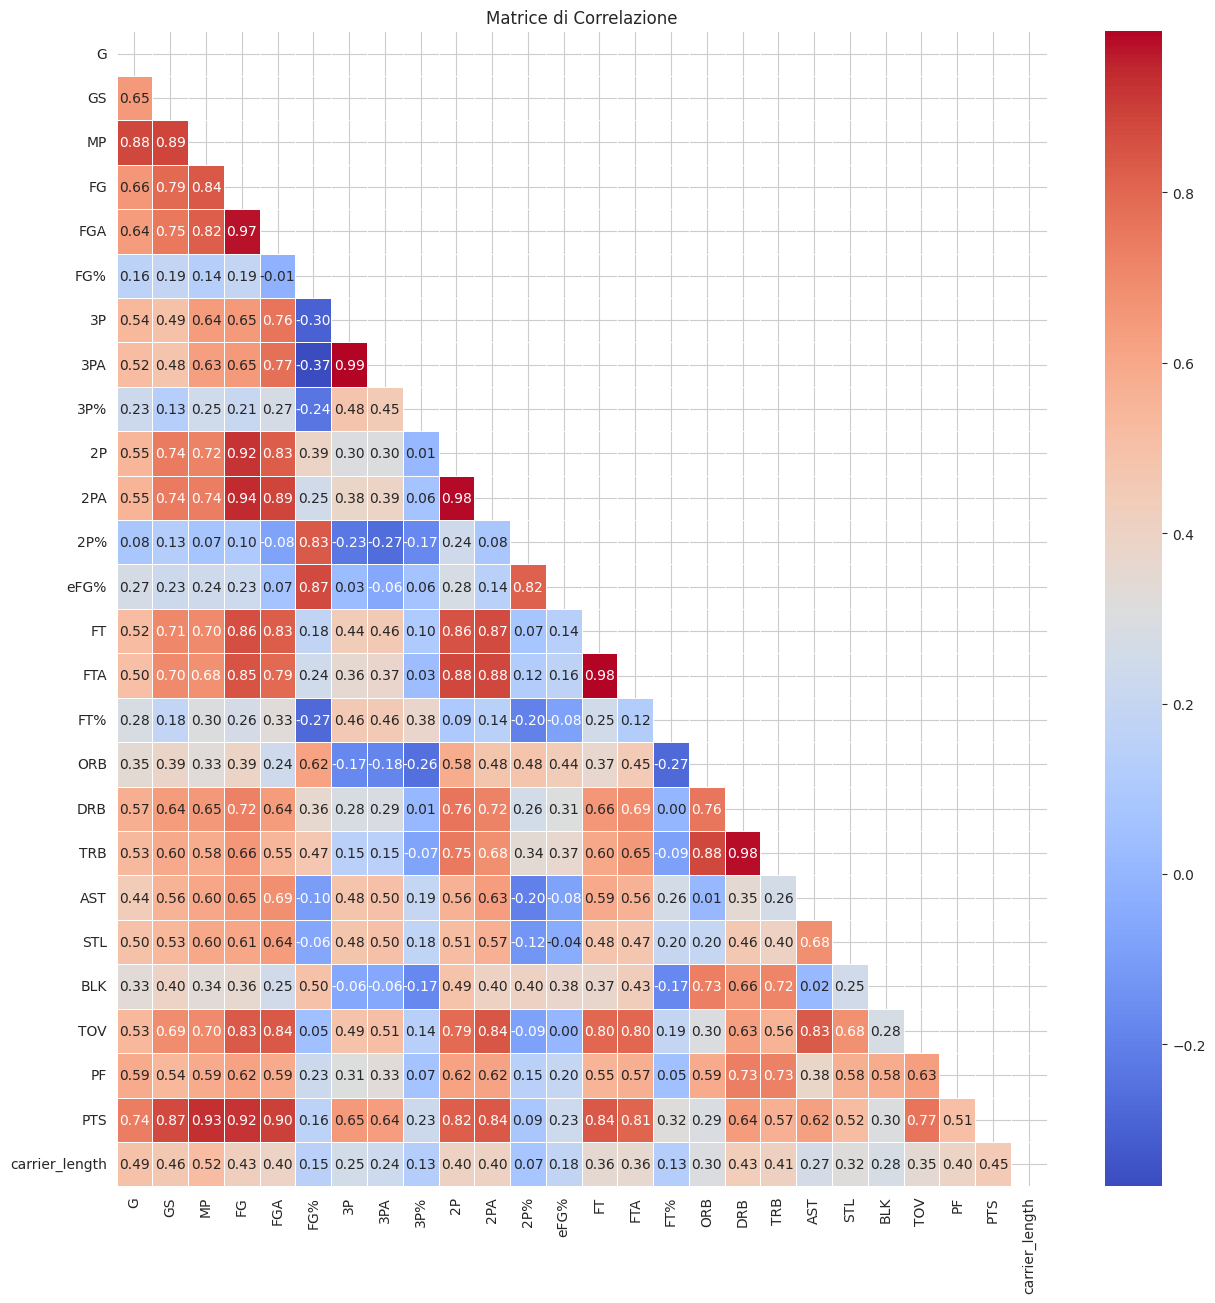

In [38]:


# Creazione di un DataFrame con i tuoi dati
# Supponendo che i tuoi dati siano già presenti in un DataFrame chiamato 'df'

# Creazione di una sottoinsieme del DataFrame con le colonne di interesse
columns_of_interest = ['G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
                        'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'carrier_length']

subset_df = final_data[columns_of_interest]

# Calcolo della matrice di correlazione
correlation_matrix = subset_df.corr()

# Creazione di una matrice con la stessa forma di quella di correlazione ma con valori NaN
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Creazione di un heatmap per visualizzare solo la metà superiore della matrice di correlazione
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title("Matrice di Correlazione")
plt.show()


**Strong Correlations with Points (PTS)**:
Field goals (FG), field goal attempts (FGA), minutes played (MP), and free throws (FT) show strong positive correlations with points scored. This suggests that players who have more playing time and shooting opportunities tend to score more.


**Other Notable Correlations**: Assists (AST), rebounds (TRB), and steals (STL) also correlate positively with points, indicating that players who contribute significantly in these areas often score higher points.

**Carrier Length**: We can notice that , carrier length has a notable correlation with the number of games (G), the number of points scored per game (PTS), and also with minutes played (MP) and others positive indicators , for the 3 first years




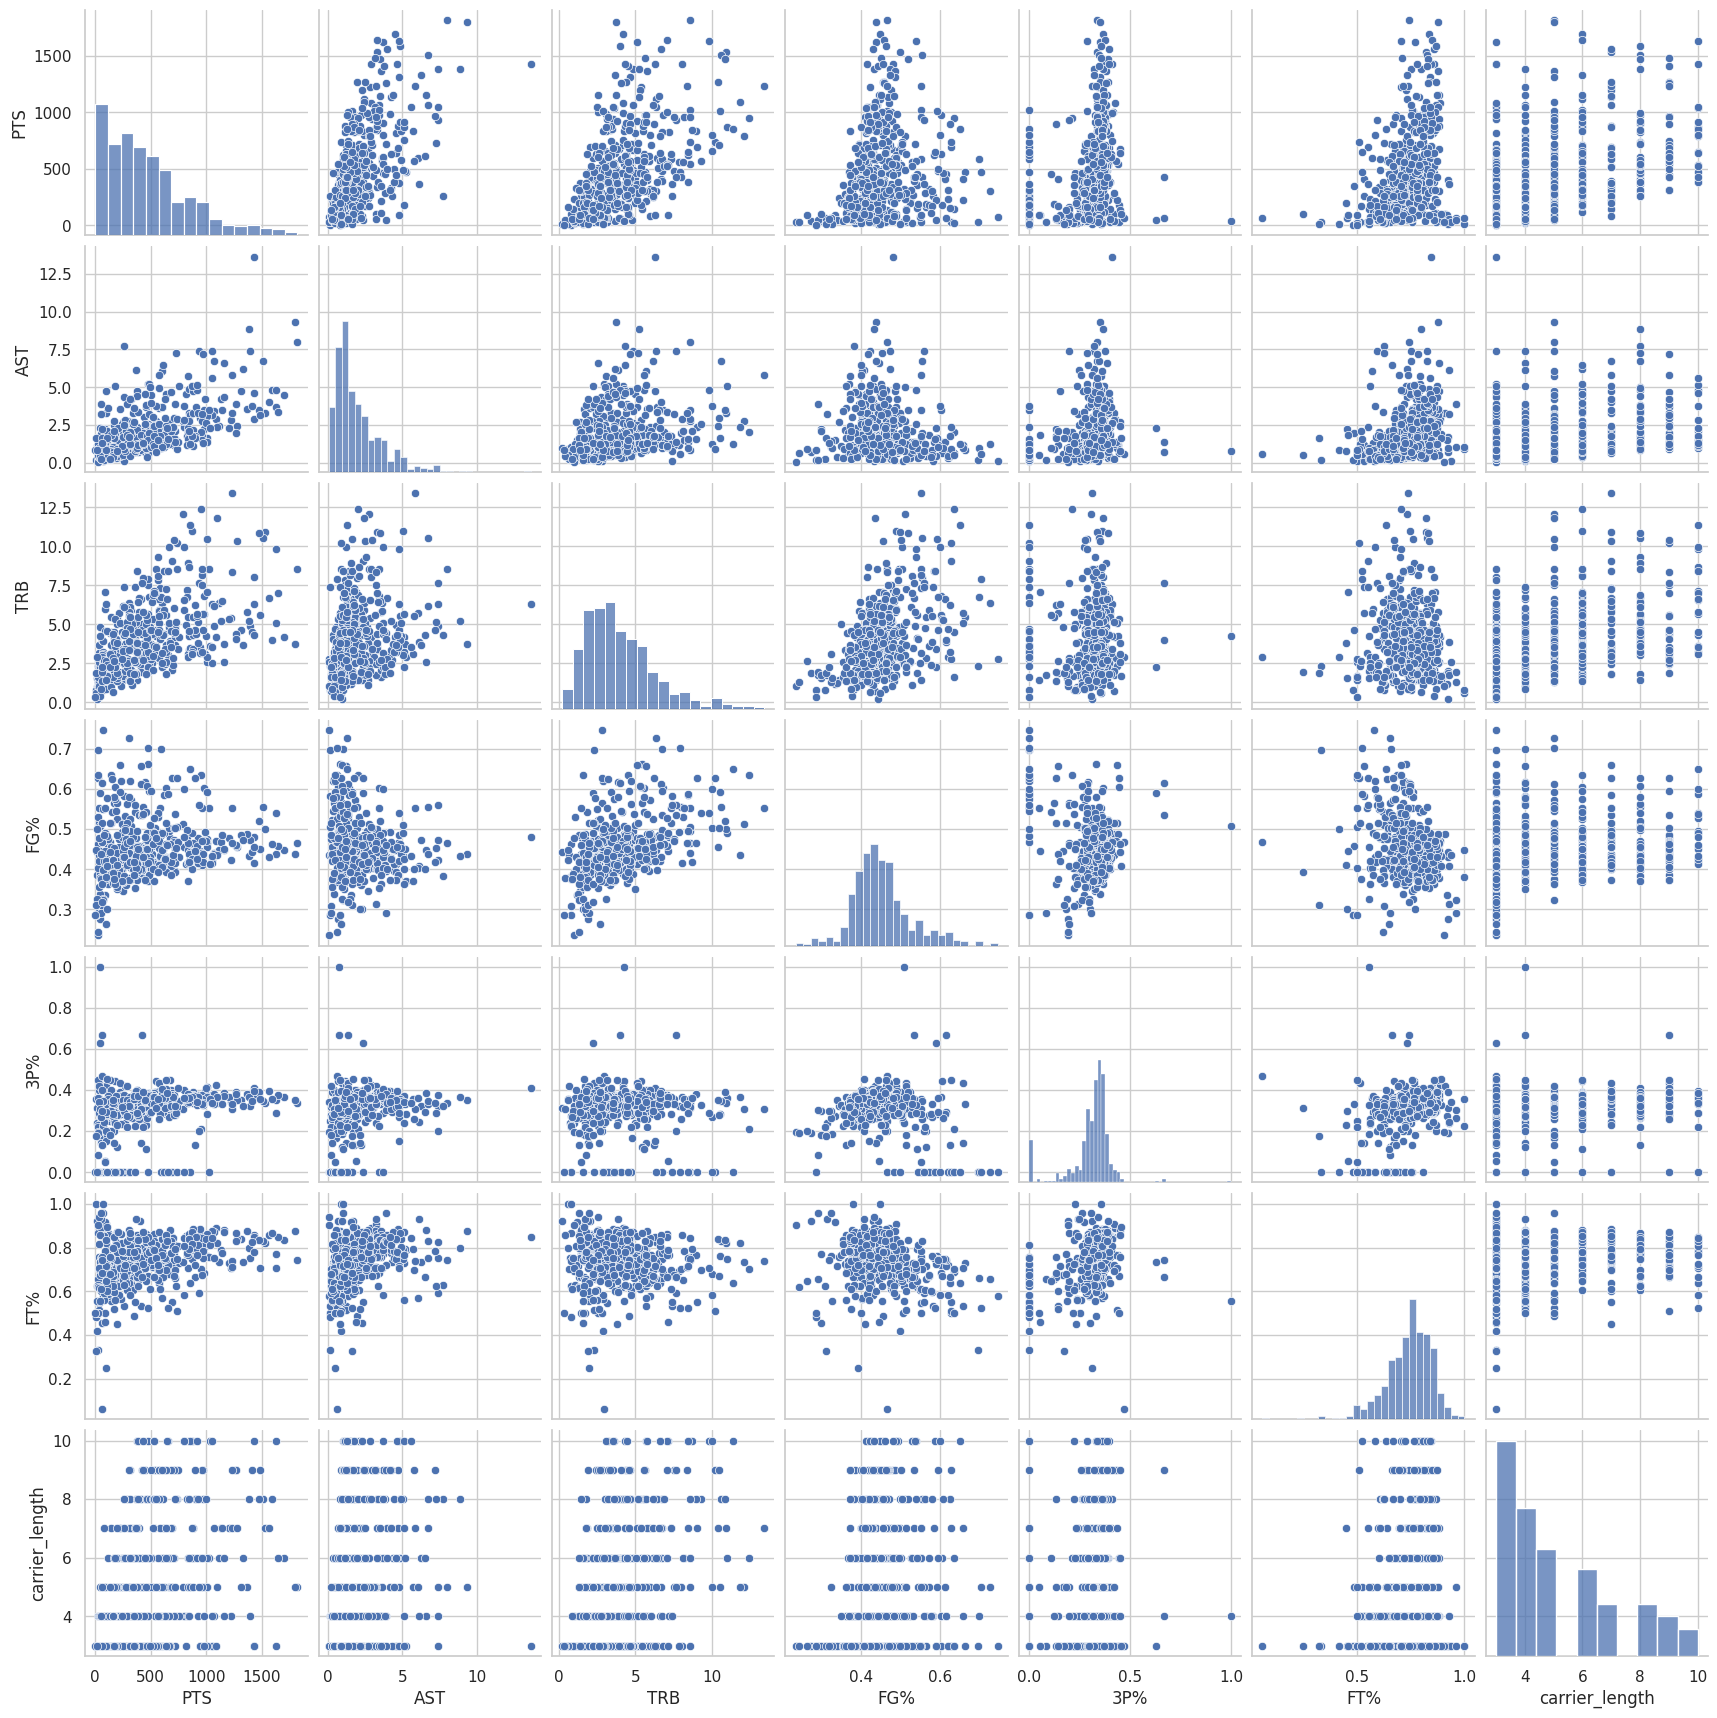

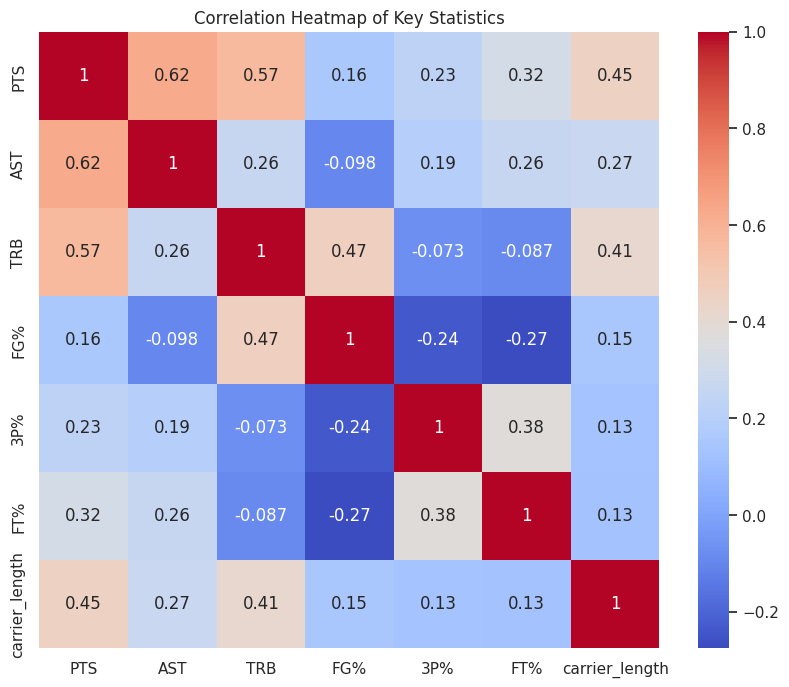

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualisation style
sns.set(style="whitegrid")

# Selecting a few key statistics for exploration
key_stats = ['PTS', 'AST', 'TRB', 'FG%', '3P%', 'FT%','carrier_length']

# Pairplot to visualize relationships between key stats
pairplot_data = final_data[key_stats]
sns.pairplot(pairplot_data)
plt.show()

# Correlation heatmap
corr = pairplot_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Key Statistics")
plt.show()


### 4.2 Features Selection

In [40]:
# Identifying numerical columns
numerical_cols = final_data.select_dtypes(include=['int64', 'float64']).columns

# Identifying categorical columns
categorical_cols = final_data.select_dtypes(include=['object', 'category']).columns

# Creating separate DataFrames
df_numerical = final_data[numerical_cols]
df_categorical = final_data[categorical_cols]



## 5. Modeling